# Branch 3: Security Threat Classification & Risk Assessment

This notebook focuses on:
- Comprehensive threat categorization and severity scoring
- Multi-dimensional risk assessment framework
- IP reputation and threat intelligence integration
- Attack pattern classification and trend analysis
- Actionable security recommendations

**Analysis Branch:** Risk Assessment & Classification

## 1. Import Libraries and Setup

In [1]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Add parent directory to path
sys.path.append('..')

# Import custom modules
from log_threat_detection.dataset import LogDataset
from log_threat_detection.models import ThreatDetector
from log_threat_detection.config import *

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('muted')

print('✓ Libraries imported successfully')

✓ Libraries imported successfully


## 2. Load and Analyze Data

In [2]:
# Initialize dataset and threat detector
dataset = LogDataset()
threat_detector = ThreatDetector()

# Load and preprocess logs
access_df, error_df = dataset.load_all()
access_df = dataset.preprocess_access_log(access_df)

# Run comprehensive threat analysis
access_df = threat_detector.analyze_threats(access_df)

print('=' * 80)
print('COMPREHENSIVE THREAT ANALYSIS')
print('=' * 80)
print(f'Total Requests: {len(access_df):,}')
print(f'Threats Detected: {access_df["threat_detected"].sum():,}')
print(f'Threat Rate: {access_df["threat_detected"].sum() / len(access_df) * 100:.2f}%')

Loaded 233930 access log entries
Loaded 5075 error log entries
COMPREHENSIVE THREAT ANALYSIS
Total Requests: 233,930
Threats Detected: 1,273
Threat Rate: 0.54%


## 3. Threat Categorization

THREAT CATEGORIZATION
                     0
SQL Injection      997
XSS Attack           0
Path Traversal      13
Suspicious Status  263


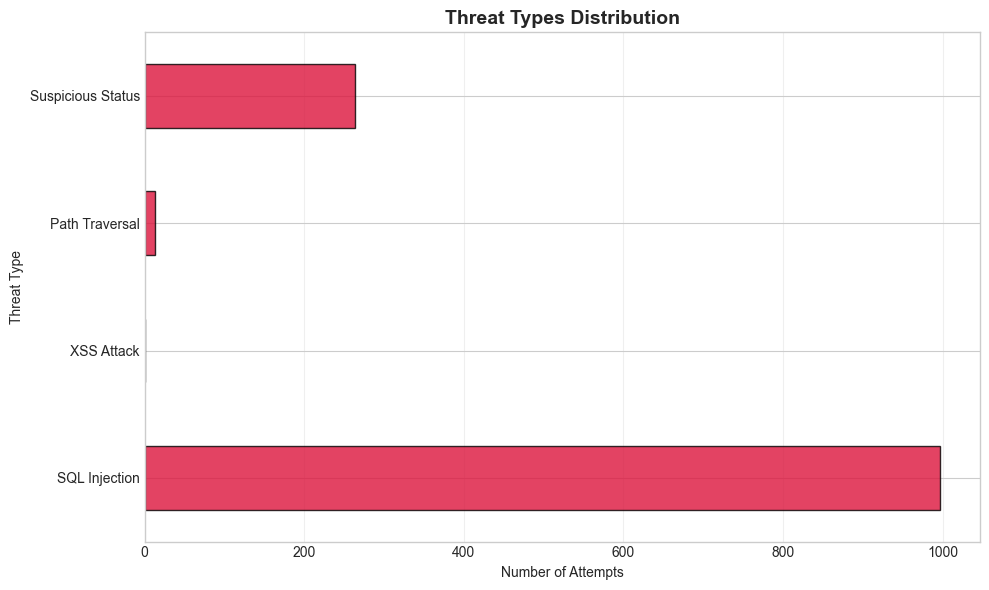

In [3]:
# Categorize threats by type
threat_categories = pd.DataFrame({
    'SQL Injection': [access_df['sql_injection'].sum()],
    'XSS Attack': [access_df['xss_attack'].sum()],
    'Path Traversal': [access_df['path_traversal'].sum()],
    'Suspicious Status': [access_df['suspicious_status'].sum()]
})

print('=' * 80)
print('THREAT CATEGORIZATION')
print('=' * 80)
print(threat_categories.T)

# Visualize threat categories
fig, ax = plt.subplots(figsize=(10, 6))
threat_categories.T.plot(kind='barh', ax=ax, legend=False, color='crimson', edgecolor='black', alpha=0.8)
ax.set_title('Threat Types Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Attempts')
ax.set_ylabel('Threat Type')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 4. Severity Scoring

In [4]:
# Calculate severity scores
def calculate_severity(row):
    severity_score = 0
    if row['sql_injection']:
        severity_score += 10
    if row['xss_attack']:
        severity_score += 8
    if row['path_traversal']:
        severity_score += 9
    if row['suspicious_status']:
        severity_score += 5
    
    if severity_score >= 15:
        return 'CRITICAL', severity_score
    elif severity_score >= 10:
        return 'HIGH', severity_score
    elif severity_score >= 5:
        return 'MEDIUM', severity_score
    elif severity_score > 0:
        return 'LOW', severity_score
    else:
        return 'NONE', 0

access_df[['threat_severity', 'threat_score']] = access_df.apply(
    calculate_severity, axis=1, result_type='expand'
)

# Analyze severity distribution
severity_dist = access_df[access_df['threat_detected']]['threat_severity'].value_counts()

print('=' * 80)
print('SEVERITY DISTRIBUTION')
print('=' * 80)
print(severity_dist)
print(f'\nCritical Threats: {(access_df["threat_severity"] == "CRITICAL").sum()}')

SEVERITY DISTRIBUTION
threat_severity
HIGH      997
MEDIUM    276
Name: count, dtype: int64

Critical Threats: 0


## 5. IP Risk Assessment

In [5]:
# Profile threat actors by IP
threat_actors = access_df[access_df['threat_detected']].groupby('ip').agg({
    'threat_detected': 'count',
    'sql_injection': 'sum',
    'xss_attack': 'sum',
    'path_traversal': 'sum',
    'threat_score': 'sum',
    'threat_severity': lambda x: (x.isin(['CRITICAL', 'HIGH'])).sum()
}).rename(columns={
    'threat_detected': 'total_threats',
    'threat_severity': 'high_severity_count'
}).sort_values('threat_score', ascending=False)

print('=' * 80)
print('TOP 10 THREAT ACTORS (IPs)')
print('=' * 80)
print(threat_actors.head(10))

# Classify IP risk levels
def classify_ip_risk(row):
    if row['high_severity_count'] >= 3 or row['threat_score'] >= 30:
        return 'CRITICAL'
    elif row['high_severity_count'] >= 1 or row['threat_score'] >= 15:
        return 'HIGH'
    elif row['threat_score'] >= 5:
        return 'MEDIUM'
    else:
        return 'LOW'

threat_actors['risk_level'] = threat_actors.apply(classify_ip_risk, axis=1)
print(f'\nRisk Level Distribution:')
print(threat_actors['risk_level'].value_counts())

TOP 10 THREAT ACTORS (IPs)
                 total_threats  sql_injection  xss_attack  path_traversal  \
ip                                                                          
203.115.97.42              175            175           0               0   
182.72.100.186              36             36           0               0   
204.10.194.152              36              0           0               0   
183.82.33.14                18             17           0               1   
170.205.31.106              27              0           0               0   
114.10.47.77                13             13           0               0   
58.26.251.212               13             13           0               0   
103.155.3.139               11             11           0               0   
152.59.147.164              11             11           0               0   
106.215.102.245             10             10           0               0   

                 threat_score  high_severity_cou

## 6. Attack Pattern Analysis

In [6]:
# Analyze attack success rates
threats_df = access_df[access_df['threat_detected']].copy()
threats_df['attack_successful'] = threats_df['status'] == 200

success_rate = threats_df['attack_successful'].mean() * 100

print('=' * 80)
print('ATTACK PATTERN ANALYSIS')
print('=' * 80)
print(f'Total Attack Attempts: {len(threats_df):,}')
print(f'Successful (200 Status): {threats_df["attack_successful"].sum():,}')
print(f'Success Rate: {success_rate:.2f}%')
print(f'\nAttacks by HTTP Method:')
print(threats_df['method'].value_counts())

# Analyze most targeted endpoints
targeted_urls = threats_df['url'].value_counts().head(10)
print(f'\nTop 10 Targeted Endpoints:')
print(targeted_urls)

ATTACK PATTERN ANALYSIS
Total Attack Attempts: 1,273
Successful (200 Status): 1,002
Success Rate: 78.71%

Attacks by HTTP Method:
method
GET     1124
POST     148
HEAD       1
Name: count, dtype: int64

Top 10 Targeted Endpoints:
url
/ewallet/module/global_ajax.php?xfor=updateidle                                        325
/website/DropDownMenuX.js                                                              157
/website/css/select2.min.css                                                           120
/website/membership/modify_member.php?&tag=all&msg=Information+successfully+updated    116
/website/jsfile/select2.min.js                                                         110
/.well-known/assetlinks.json                                                            91
/website/membership/modify_member.php?&tag=&msg=Information+successfully+updated        43
/website/membership/modify_member.php?&tag=new&msg=Information+successfully+updated     27
/robots.txt                           

## 7. Risk Dashboard

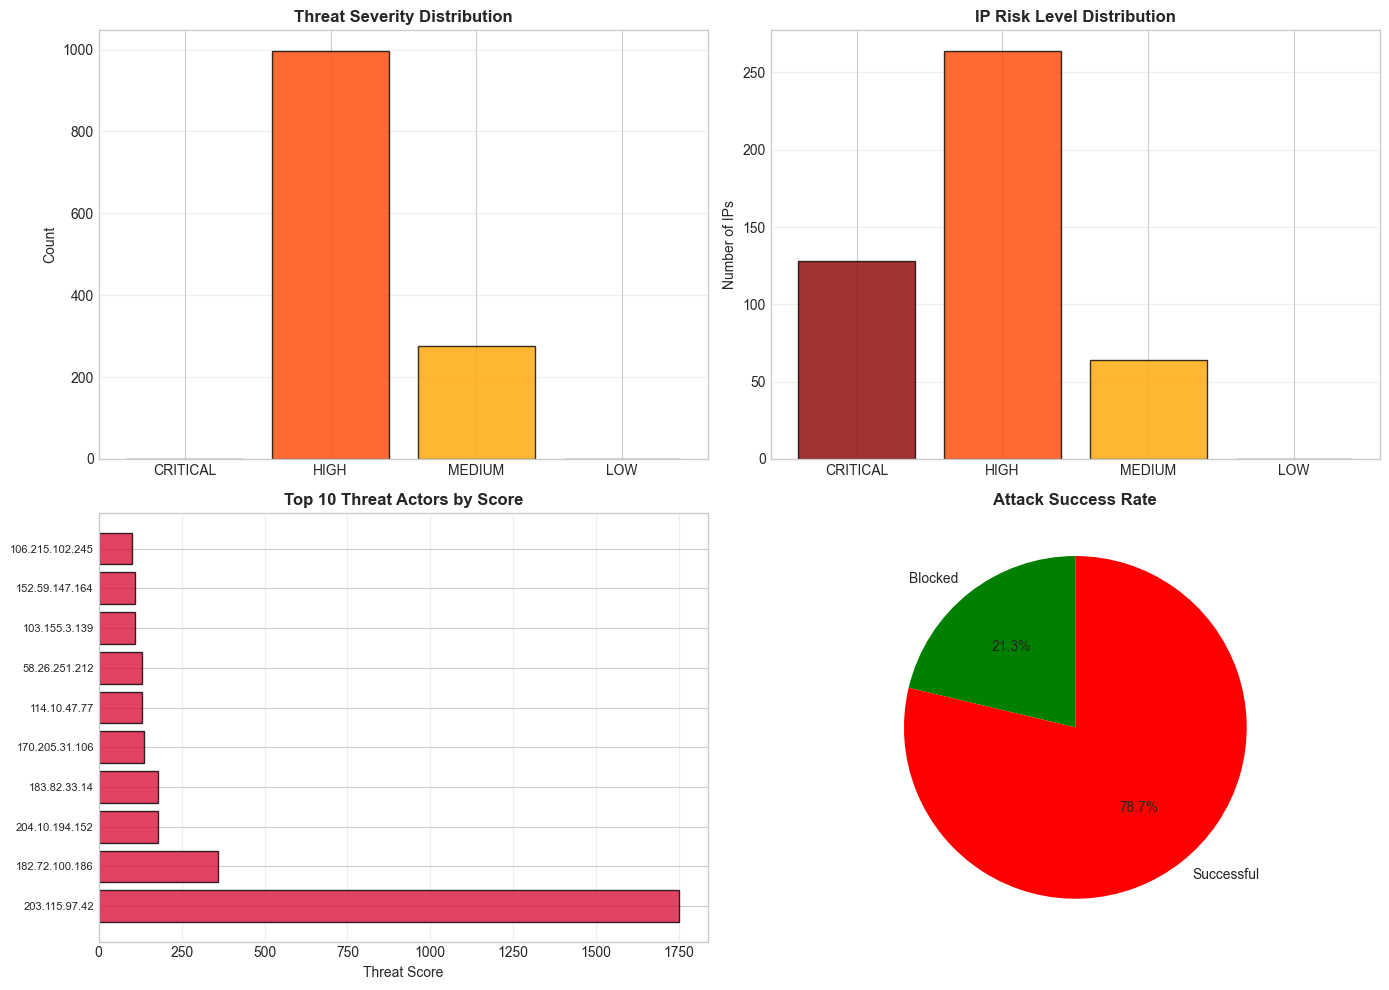

In [7]:
# Create comprehensive risk dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Severity distribution
severity_order = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']
severity_colors = {'CRITICAL': 'darkred', 'HIGH': 'orangered', 'MEDIUM': 'orange', 'LOW': 'gold'}
severity_data = severity_dist.reindex(severity_order, fill_value=0)
axes[0, 0].bar(severity_data.index, severity_data.values, 
               color=[severity_colors[s] for s in severity_data.index], edgecolor='black', alpha=0.8)
axes[0, 0].set_title('Threat Severity Distribution', fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. IP risk levels
risk_dist = threat_actors['risk_level'].value_counts().reindex(severity_order, fill_value=0)
axes[0, 1].bar(risk_dist.index, risk_dist.values,
               color=[severity_colors[s] for s in risk_dist.index], edgecolor='black', alpha=0.8)
axes[0, 1].set_title('IP Risk Level Distribution', fontweight='bold')
axes[0, 1].set_ylabel('Number of IPs')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Top threat actors
top_actors = threat_actors.head(10)
axes[1, 0].barh(range(len(top_actors)), top_actors['threat_score'].values, color='crimson', edgecolor='black', alpha=0.8)
axes[1, 0].set_yticks(range(len(top_actors)))
axes[1, 0].set_yticklabels(top_actors.index, fontsize=8)
axes[1, 0].set_title('Top 10 Threat Actors by Score', fontweight='bold')
axes[1, 0].set_xlabel('Threat Score')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Attack success rate
success_data = pd.DataFrame({
    'Status': ['Blocked', 'Successful'],
    'Count': [len(threats_df) - threats_df['attack_successful'].sum(), threats_df['attack_successful'].sum()]
})
axes[1, 1].pie(success_data['Count'], labels=success_data['Status'], autopct='%1.1f%%',
               colors=['green', 'red'], startangle=90)
axes[1, 1].set_title('Attack Success Rate', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Save Results

In [8]:
# Save classification results
output_dir = '../results'
import os
os.makedirs(output_dir, exist_ok=True)

# Save threat actors
threat_actors.to_csv(f'{output_dir}/threat_actors.csv')
print(f'✓ Saved {len(threat_actors)} threat actor profiles')

# Save critical threats
critical_threats = access_df[access_df['threat_severity'] == 'CRITICAL']
if len(critical_threats) > 0:
    critical_threats.to_csv(f'{output_dir}/critical_threats.csv', index=False)
    print(f'✓ Saved {len(critical_threats)} critical threats')

# Save high-risk IPs
high_risk_ips = threat_actors[threat_actors['risk_level'].isin(['CRITICAL', 'HIGH'])]
if len(high_risk_ips) > 0:
    high_risk_ips.to_csv(f'{output_dir}/high_risk_ips.csv')
    print(f'✓ Saved {len(high_risk_ips)} high-risk IPs')

print(f'\n✓ All results saved to {output_dir}/')

✓ Saved 456 threat actor profiles
✓ Saved 392 high-risk IPs

✓ All results saved to ../results/


## 9. Actionable Recommendations

### Immediate Actions (Next 24 hours):
1. **CRITICAL IPs**: Block or rate-limit IPs with CRITICAL risk level
2. **Active Threats**: Investigate successful attacks (200 status with threats)
3. **Vulnerable Endpoints**: Patch the top 10 most targeted URLs

### Short-term (This Week):
1. **WAF Rules**: Deploy updated Web Application Firewall rules
2. **Input Validation**: Implement strict validation on vulnerable endpoints
3. **Monitoring**: Set up real-time alerting for CRITICAL/HIGH severity threats
4. **Access Controls**: Review and strengthen authentication mechanisms

### Long-term (This Month):
1. **Security Audit**: Conduct comprehensive code review of targeted components
2. **Penetration Testing**: Perform professional security assessment
3. **Training**: Educate development team on secure coding practices
4. **Architecture**: Consider implementing defense-in-depth strategies

### Key Metrics to Monitor:
- Threat detection rate trending
- Attack success rate (should decrease)
- Number of high-risk IPs (should decrease)
- Mean time to detect and respond to threats